In [1]:
from flax import nnx 

import jax
import jax.numpy as jnp
from jax import random
from typing import Optional
import matplotlib.pyplot as plt

import torch
import cv2 
import numpy as np

In [2]:
from superpoint_jax import SuperPoint as SP_jax
from superpoint_torch import SuperPoint as SP_torch

In [3]:
def plot_imgs(imgs, titles=None, cmap='brg', ylabel='', normalize=False, ax=None, dpi=100):
    """
        https://github.com/rpautrat/SuperPoint/blob/master/notebooks/utils.py
    """
    n = len(imgs)
    if not isinstance(cmap, list):
        cmap = [cmap]*n
    if ax is None:
        _, ax = plt.subplots(1, n, figsize=(6*n, 6), dpi=dpi)
        if n == 1:
            ax = [ax]
    else:
        if not isinstance(ax, list):
            ax = [ax]
        assert len(ax) == len(imgs)
    for i in range(n):
        if imgs[i].shape[-1] == 3:
            imgs[i] = imgs[i][..., ::-1]  # BGR to RGB
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmap[i]),
                     vmin=None if normalize else 0,
                     vmax=None if normalize else 1)
        if titles:
            ax[i].set_title(titles[i])
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
    ax[0].set_ylabel(ylabel)
    plt.tight_layout()

100.0%


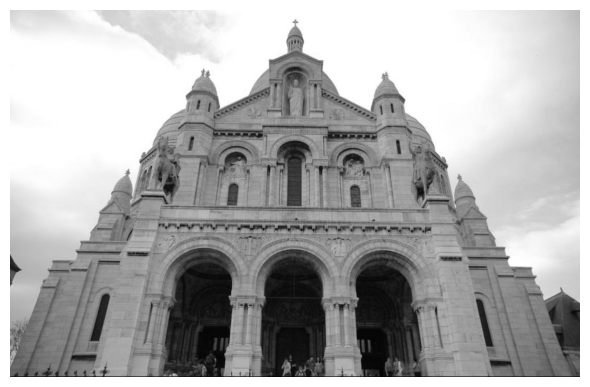

In [4]:
image_url = 'https://raw.githubusercontent.com/cvg/Hierarchical-Localization/master/datasets/sacre_coeur/mapping/03903474_1471484089.jpg'
image_path = 'image_sacre_coeur.jpg'
torch.hub.download_url_to_file(image_url, image_path)

image = cv2.imread(image_path).mean(-1) / 255
image = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])
plot_imgs([image], cmap='gray')

In [5]:
detection_thresh = 0.005
nms_radius = 5
path_pretrained_model = 'superpoint_v6_from_tf.pth'

sp_torch = SP_torch(detection_threshold=detection_thresh, nms_radius=nms_radius).eval()
state_dict = torch.load(path_pretrained_model)
sp_torch.load_state_dict(state_dict)

/tmp/ipykernel_711452/3606411061.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_pretrained_model)


<All keys matched successfully>

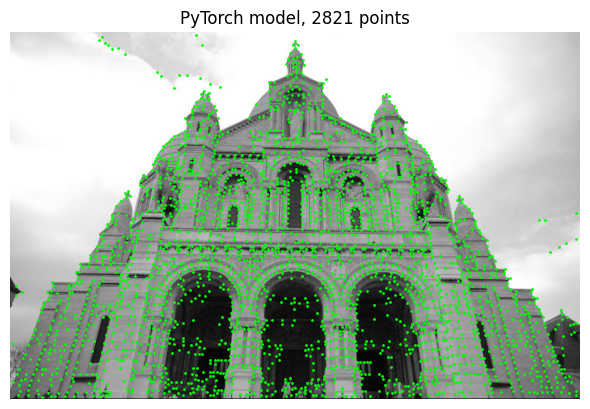

In [6]:
with torch.no_grad():
    pred_th = sp_torch({'image': torch.from_numpy(image[None,None]).float()})
points_th = pred_th['keypoints'][0]
plot_imgs([image], cmap='gray', titles=[f'PyTorch model, {len(points_th)} points'])
plt.scatter(*points_th.T, lw=0, s=4, c='lime')

In [7]:
import jax
import jax.numpy as jnp

from flax import nnx
def load_pytorch_superpoint_state(flax_model: "SuperPoint", torch_state_dict: dict) -> "SuperPoint":
    """
    Loads PyTorch SuperPoint weights into a Flax NNX SuperPoint model in-place.
    
    Args:
      flax_model: an instance of the Flax NNX SuperPoint class (already constructed).
      torch_state_dict: a dict of parameter_name -> torch.Tensor from PyTorch's state_dict().
    
    Returns:
      The same `flax_model` with updated parameters.
    """
    # 1) Collect references to submodule variables:
    #    We'll store them in path_to_var, mapping from e.g. "backbone.0.1.bn.bias" -> nnx.Variable
    path_to_var = {}
    for path, submodule in flax_model.iter_modules():
        # submodule might itself hold nnx.Variables as attributes (kernel, bias, etc.).
        # We'll gather those.
        if hasattr(submodule, "__dict__"):  # if it's a Module
            for attr_name in list(submodule.__dict__):
                attr_val = getattr(submodule, attr_name)
                if isinstance(attr_val, nnx.Variable):
                    # Convert all path items (which can be strings or ints) into strings
                    # then join with "." 
                    str_path = ".".join(map(str, (*path, attr_name)))
                    # e.g. ('backbone', 0, 1), 'bias' => "backbone.0.1.bias"
                    path_to_var[str_path] = attr_val

    # 2) We'll map certain PyTorch BN keys to Flax BN keys.
    bn_key_map = {
        "weight": "scale",
        "bias": "bias",
        "running_mean": "mean",
        "running_var": "var",
    }

    # 3) Iterate over the torch_state_dict items, find the corresponding path, reshape if needed.
    for torch_name, torch_tensor in torch_state_dict.items():
        # Example PyTorch name: "backbone.0.0.conv.weight"
        # We'll rename to match Flax naming:
        flax_name = torch_name

        # Replace BN keys
        for old, new in bn_key_map.items():
            flax_name = flax_name.replace(f".bn.{old}", f".bn.{new}")

        # Replace conv weight/bias
        flax_name = flax_name.replace(".conv.weight", ".conv.kernel")
        flax_name = flax_name.replace(".conv.bias", ".conv.bias")

        # If your PyTorch code has different naming (like "detector_head", "descriptor_head"),
        # you might do additional replacements. For example:
        # flax_name = flax_name.replace("detector.", "detector_head.")
        # flax_name = flax_name.replace("descriptor.", "descriptor_head.")

        # Now see if we have a matching entry in path_to_var
        if flax_name not in path_to_var:
            # Possibly a mismatch or extra parameter. For debugging:
            # print(f"[WARNING] No match in Flax for {torch_name} => {flax_name}")
            continue

        flax_var = path_to_var[flax_name]  # The nnx.Variable object

        # Convert PyTorch tensor -> jax.Array
        arr = jnp.array(torch_tensor.cpu().numpy())

        # If it's a conv kernel, reorder from (out_ch, in_ch, kH, kW) -> (kH, kW, in_ch, out_ch)
        if ".conv.kernel" in flax_name:
            arr = jnp.transpose(arr, (2, 3, 1, 0))

        # Optional: if you store BN var with or without epsilon adjustments, 
        # you might need to do something extra. Usually direct assignment is fine.

        # Check shape match
        if arr.shape != flax_var.value.shape:
            raise ValueError(
                f"Shape mismatch for {torch_name} -> {flax_name}:\n"
                f"  Torch: {arr.shape}, Flax: {flax_var.value.shape}"
            )

        # Assign
        flax_var.value = arr

    return flax_model


In [8]:
# Then we have our Flax NNX model:
flax_model = SP_jax(rngs=nnx.Rngs(0))

# Convert weights:
load_pytorch_superpoint_state(flax_model, state_dict)


SuperPoint(
  conf=namespace(nms_radius=4, max_num_keypoints=None, detection_threshold=0.005, remove_borders=4, descriptor_dim=256, channels=[64, 64, 128, 128, 256]),
  stride=8,
  backbone_layers=[VGGBlock(
    conv=Conv(
      kernel_shape=(3, 3, 1, 64),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64,), dtype=float32)
      ),
      in_features=1,
      out_features=64,
      kernel_size=(3, 3),
      strides=(1, 1),
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=<class 'jax.numpy.float32'>,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7f39c0707640>,
      bias_init=<function zeros at 0x7f39c0f40670>,
      conv_general_dilated=<function conv_general_dilated at 0x7f39c175bbe0>
    ),
    relu=True,
    bn=BatchN

In [16]:
len(pred_jax['keypoint_scores'][0])

12993

2025-01-20 14:48:07.408561: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-20 14:48:07.541354: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-20 14:48:07.650693: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-20 14:48:07.806230: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-20 14:48:11.715076: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86

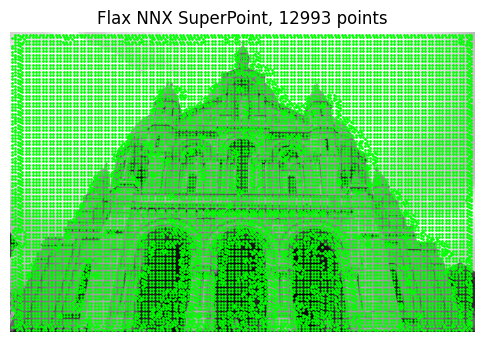

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Suppose `image` is shape (H, W) in float32 or float64
# Suppose `sp_jax` is your Flax NNX SuperPoint model

# 1. Convert the image to the shape [batch, H, W, 1] for NNX
#    (Because our Flax model expects NHWC.)
image_jax = jnp.array(image, dtype=jnp.float32)[..., None]  # shape => (H, W, 1)
image_jax = image_jax[None]  # shape => (1, H, W, 1)

# 2. Run inference
pred_jax = flax_model({"image": image_jax})
points_jax = pred_jax['keypoints'][0]  # shape => (N, 2)
# points_jax[:, 0] is x-coord, points_jax[:, 1] is y-coord

# 3. Plot the image and overlay the keypoints
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.scatter(points_jax[:, 0], points_jax[:, 1], s=4, c='lime', lw=0)
plt.title(f'Flax NNX SuperPoint, {len(points_jax)} points')
plt.axis('off')
plt.show()